# Baseline BERT Model

In [2]:
# Append the directory containing the src folder to sys.path
import sys

sys.path.append('/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift')

In [11]:
%pip install /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl

Processing /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl
  Using cached tensorflow_macos-2.15.1-cp310-cp310-macosx_12_0_arm64.whl (2.2 kB)
  Attempting uninstall: tensorflow-text
    Found existing installation: tensorflow-text 2.16.1
    Uninstalling tensorflow-text-2.16.1:
      Successfully uninstalled tensorflow-text-2.16.1
You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install -U "tf-models-official==2.15.*"

  Using cached tf_models_official-2.15.0-py2.py3-none-any.whl (2.7 MB)
  Using cached sacrebleu-2.4.2-py3-none-any.whl (106 kB)
  Using cached pycocotools-2.0.7-cp310-cp310-macosx_10_9_universal2.whl (169 kB)
  Using cached tensorflow_datasets-4.9.4-py3-none-any.whl (5.1 MB)
  Using cached google_api_python_client-2.129.0-py2.py3-none-any.whl (11.6 MB)
  Using cached kaggle-1.6.12-py3-none-any.whl
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
  Using cached sentencepiece-0.2.0-cp310-cp310-macosx_11_0_arm64.whl (1.2 MB)
  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (35.4 MB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached immutabledict-4.2.0-py3-none-any.whl (4.7 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached Cython-3.0.10-py2.py3-none-any.whl (1.2 MB)
  Using 

In [6]:
#Path variables for datasets
directory = "/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift"
path_raw = "/data/raw/"
path_interim = "/data/interim/"
path_processed = "/data/processed/"

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow_text as text
import tensorflow_hub as hub
from src.data.data_manager import data_loader, save_event_log, delete_dataframes
import numpy as np


TensorFlow version: 2.15.1


In [4]:
print("TensorFlow version:", text.__version__)

TensorFlow version: 2.15.0


In [7]:
train_tensor = data_loader(directory, path_interim, "Train")
val_tensor = data_loader(directory, path_interim, "Val")
test_tensor = data_loader(directory, path_interim, "Test")

In [8]:
train_tensor

,Prefix_Trace,Next_Activity
0,assign-seriousness,take-in-charge-ticket
1,assign-seriousness take-in-charge-ticket,take-in-charge-ticket
2,assign-seriousness take-in-charge-ticket take-...,resolve-ticket
3,assign-seriousness take-in-charge-ticket take-...,closed
4,assign-seriousness take-in-charge-ticket take-...,end
...,...,...
13170,assign-seriousness,take-in-charge-ticket
13171,assign-seriousness take-in-charge-ticket,wait
13172,assign-seriousness take-in-charge-ticket wait,resolve-ticket
13173,assign-seriousness take-in-charge-ticket wait ...,closed


In [9]:
class BERTPreprocessor:
    '''
    The BERTPreprocessor class is designed to preprocess event log data for input into a BERT model from TensorFlow Hub. 
    It tokenizes prefix traces and maps next activities to integer class labels suitable for multi-class classification tasks.

    Attributes:
        - preprocessor: hub.KerasLayer - the preprocessor used to convert text into BERT-compatible tokens.
        - max_length: int - the maximum sequence length for tokenized inputs.
        - activity_to_label: dict - a mapping from activity names to integer class labels.
        - label_to_activity: dict - a mapping from integer class labels to activity names.
        - next_label_index: int - the next available index for new class labels.

    Methods:
        - fit_activity_labels(df): Fits activity labels from the training dataframe.
        - preprocess(df): Preprocesses the input dataframe and returns a dictionary containing BERT-compatible inputs and labels.
    '''

    def __init__(self, max_length=512):
        '''
        Initializes the BERTPreprocessor with a specified maximum sequence length.

        Input:
            - max_length (optional): int - maximum length for tokenized sequences. Default is 512.
        '''

        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        self.max_length = max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        '''
        Fits the activity labels from the provided dataframe, creating a mapping from activity names to integer class labels.

        Input:
            - df: dataframe - dataframe containing event data with a 'Next_Activity' column.
        '''

        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        '''
        Preprocesses the input dataframe by tokenizing the prefix traces and mapping next activities to integer class labels.
        Returns a dictionary containing BERT-compatible inputs and labels.

        Input:
            - df: dataframe - dataframe containing event data with 'Prefix_Trace' and 'Next_Activity' columns.

        Output:
            - A dictionary with the following keys:
                - input_word_ids: tensor - token IDs for each prefix trace.
                - input_mask: tensor - attention masks indicating real tokens and padding tokens.
                - input_type_ids: tensor - token type IDs (all zeros for single sentences).
                - labels: tensor - integer class labels for the next activities.
        '''

        # Preprocess text data
        text_inputs = df['Prefix_Trace'].tolist()
        preprocessed_text = self.preprocessor(text_inputs)

        # Map next activities to integer class labels
        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        # Convert to tensors
        labels = tf.convert_to_tensor(labels)

        # Add labels to the preprocessed text inputs
        preprocessed_text['labels'] = labels

        return preprocessed_text


In [10]:
preprocessor = BERTPreprocessor()
preprocessor.fit_activity_labels(train_tensor)  # Fit activity labels on the training set

bert_input_train = preprocessor.preprocess(train_tensor)


print(bert_input_train)

{'input_mask': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
array([[  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       ...,
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0],
       [  101, 23911,  1011, ...,     0,     0,     0]], dtyp

# Test

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# URLs for the pre-trained BERT model and the preprocessor
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# Define the input layer for text data
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# Preprocess the input text
preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocess')
encoder_inputs = preprocess_layer(text_input)

# Get BERT outputs
encoder_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
encoder_outputs = encoder_layer(encoder_inputs)
pooled_output = encoder_outputs['pooled_output']

# Add dropout and dense layers
dropout = tf.keras.layers.Dropout(0.1)(pooled_output)
output = tf.keras.layers.Dense(10)(dropout)

# Create the model
model = tf.keras.Model(inputs=text_input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Build the model with a dummy input to initialize the layers
dummy_input = tf.constant(["dummy input"])
model(dummy_input)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocess (KerasLayer)     {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

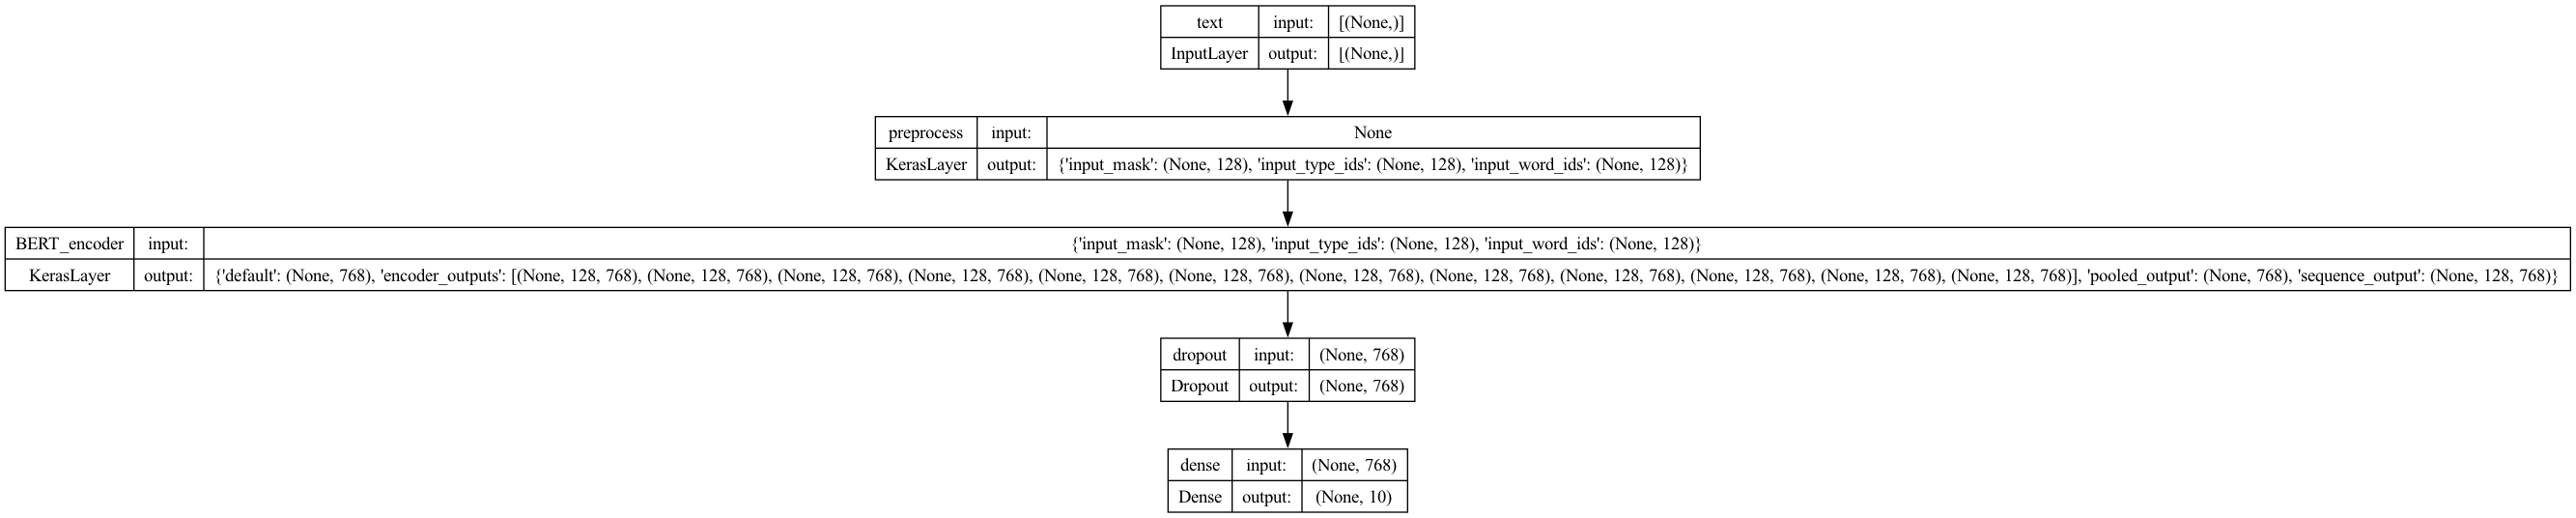

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)


In [14]:
def build_model(max_length, num_classes):
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_type_ids')
    
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True)
    
    bert_inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }
    
    bert_outputs = bert_encoder(bert_inputs)
    pooled_output = bert_outputs['pooled_output']
    
    dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(dropout)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    
    return model

# Preprocess the dataset
preprocessed_data = bert_input_train

# Extract the necessary components
input_word_ids = preprocessed_data['input_word_ids']
input_mask = preprocessed_data['input_mask']
input_type_ids = preprocessed_data['input_type_ids']

# Map the next activities to labels
activities = train_tensor['Next_Activity'].unique()
activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
labels = [activity_to_label[activity] for activity in train_tensor['Next_Activity']]
labels = tf.convert_to_tensor(labels)

# Build and compile the model
num_classes = len(activity_to_label)
model = build_model(max_length=512, num_classes=num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Train the model
model.fit(
    [input_word_ids, input_mask, input_type_ids], 
    labels, 
    epochs=3, 
    batch_size=32, 
    validation_split=0.1
)


ValueError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs={'input_word_ids': '<KerasTensor shape=(None, 512), dtype=int32, sparse=None, name=input_word_ids>', 'input_mask': '<KerasTensor shape=(None, 512), dtype=int32, sparse=None, name=input_mask>', 'input_type_ids': '<KerasTensor shape=(None, 512), dtype=int32, sparse=None, name=input_type_ids>'}
  • training=None